In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datasets
from data_analysis import (read_steering_results, plot_steering_results,read_steering_results_from_hub, 
    read_steering_results_from_hub_multiproc,DIR,MUTATIONS_RENAMED)
from huggingface_hub import hf_hub_download,snapshot_download
import os
import sys
import pandas as pd
os.environ['PYTHONPATH'] = '/home/franlucc/projects/codetrace'
sys.path.insert(0, os.environ['PYTHONPATH'])
from codetrace.utils import *

os.environ["HF_HUB_DISABLE_PROGRESS_BARS"]="true"
datasets.disable_progress_bars()

/mnt/ssd/franlucc/envs/interp/lib/python3.10/site-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [3]:
#prefetch
cache_dir = snapshot_download(repo_id="nuprl-staging/type-steering-results", repo_type="dataset", local_dir="/tmp/cached_steering_results")
cache_dir

Fetching 821 files:   0%|          | 0/821 [00:00<?, ?it/s]

'/tmp/cached_steering_results'

In [4]:
qwen_results, missing_results = read_steering_results_from_hub_multiproc("py","qwen2p5_coder_7b_base",28,5, cache_dir = cache_dir, num_proc=40)
print(qwen_results, missing_results)

Applying: 100%|██████████| 42/42 [00:24<00:00,  1.73it/s]

    num_succ  tot_succ  mean_succ  rand_num_succ  rand_tot_succ  \
0          2       100       0.02              0            100   
0          5       100       0.05              0            100   
0          4       100       0.04              0            100   
0          9       100       0.09              0            100   
0          3       100       0.03              0            100   
..       ...       ...        ...            ...            ...   
0         67       100       0.67             10            100   
0          5       100       0.05             15            100   
0         10       100       0.10              9            100   
0         24       100       0.24             15            100   
0         64       100       0.64             14            100   

    rand_mean_succ  steering_num_succ  steering_tot_succ  steering_mean_succ  \
0             0.00               29.0              985.0            0.029442   
0             0.00              124

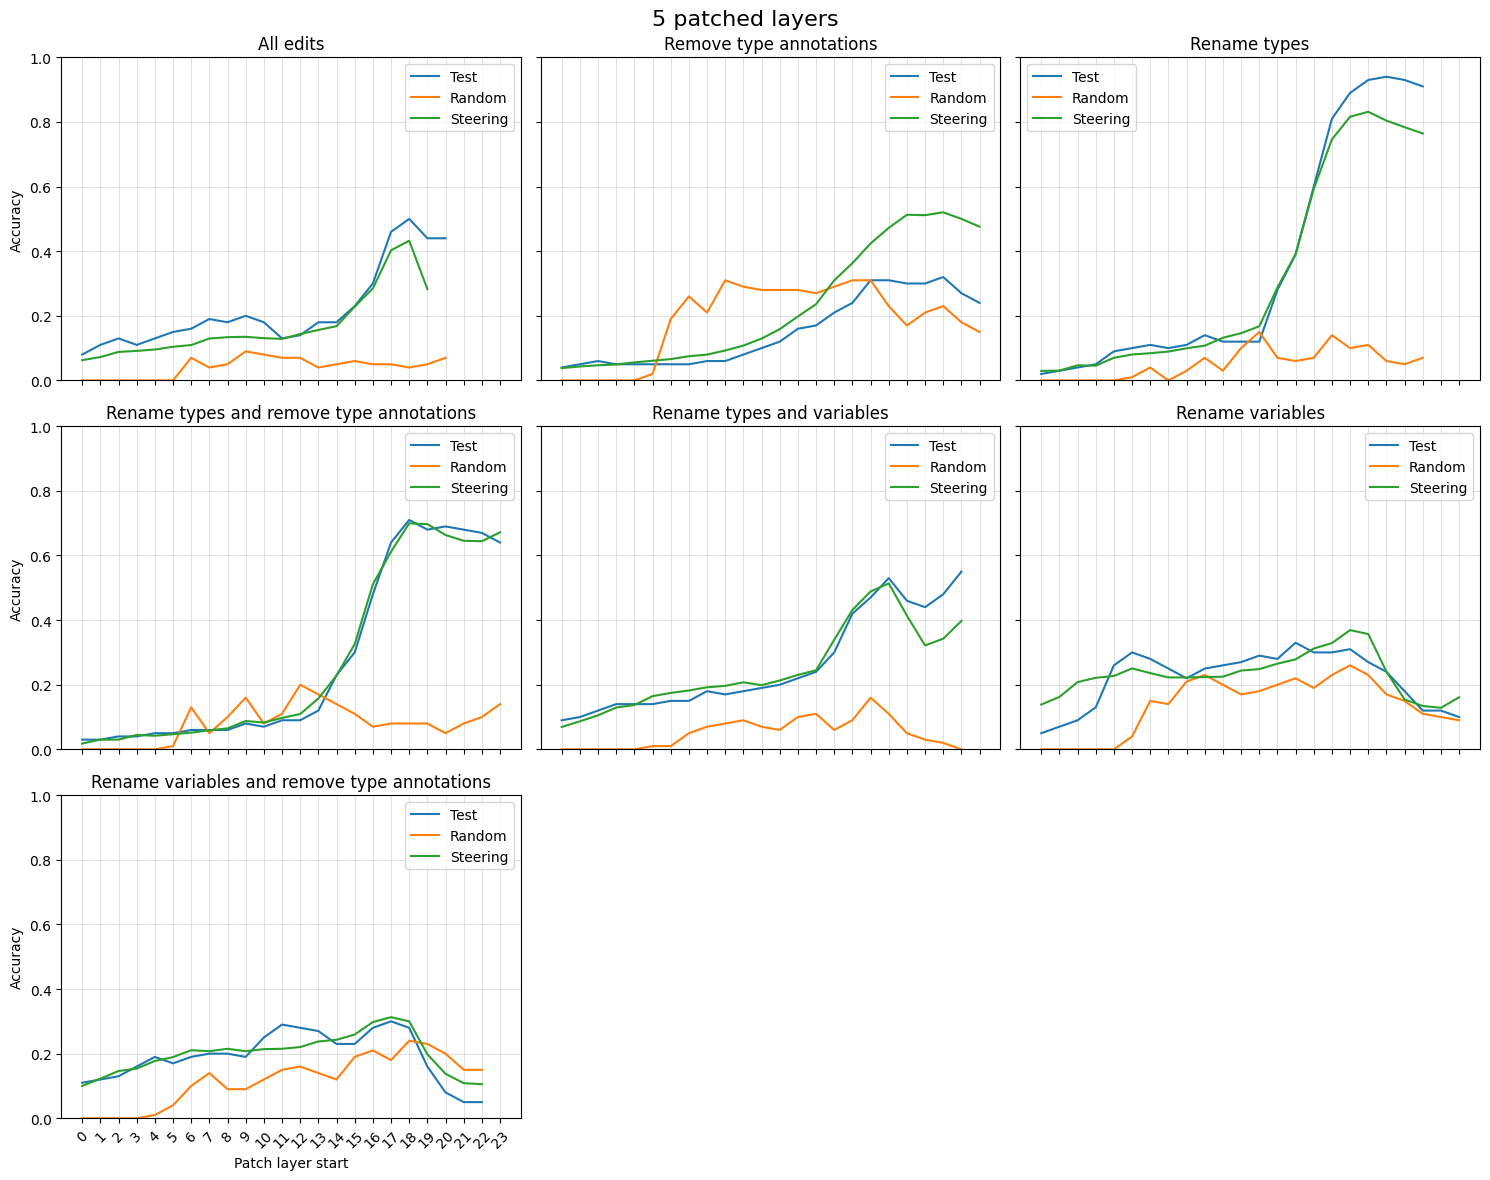

In [7]:
df_pretty = qwen_results.copy()
df_pretty["mutations"] = df_pretty["mutations"].apply(lambda x: MUTATIONS_RENAMED[x])
df_pretty = df_pretty.sort_values(["mutations","layers"])
plot_steering_results(df_pretty, 5)